#Partiendo de la limpieza de datos realizada previamente, se utiliza LSTM para predecir la producción de pozos de petroleo.





In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_clean_2024-05-13_17:08:31.csv", index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230490 entries, 0 to 230489
Data columns (total 47 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   idempresa                230490 non-null  object 
 1   anio                     230490 non-null  int64  
 2   mes                      230490 non-null  int64  
 3   idpozo                   230490 non-null  int64  
 4   prod_pet                 230490 non-null  float64
 5   prod_gas                 230490 non-null  float64
 6   prod_agua                230490 non-null  float64
 7   iny_agua                 230490 non-null  float64
 8   iny_gas                  230490 non-null  float64
 9   iny_co2                  230490 non-null  float64
 10  iny_otro                 230490 non-null  float64
 11  tef                      230490 non-null  float64
 12  tipoextraccion           230490 non-null  object 
 13  tipoestado               230490 non-null  object 
 14  tipopozo 

In [4]:
dataset = dataset[dataset['anio'] >= 2014]
#dataset = dataset[dataset['anio'] < 2024]

#dataset

In [5]:
mes_values = dataset['mes'].values

# Analisis exploratorio para ver los posibles valores de los meses.
print("Values of the 'mes' column:")
#for value in mes_values:
#  print(value)

for i, value in enumerate(mes_values):
    if i < 10:
        print(value)
    else:
        break

Values of the 'mes' column:
1
1
1
1
1
1
1
1
1
1


In [6]:
# Buscamos los pozos con mayor produccion, pero solo como análisis exploratorio.
dataset.groupby(["idpozo"])["prod_pet"].sum().sort_values()

idpozo
162231         0.00
162707         0.00
162706         0.00
146998         0.00
146997         0.00
            ...    
160693    168629.24
160932    181682.76
162246    192450.52
160694    194080.48
159848    195073.32
Name: prod_pet, Length: 3308, dtype: float64

In [7]:
# Seleccionar características relevantes
features = ['prod_pet', 'anio', 'mes', 'idpozo', 'prod_gas', 'prod_agua', 'tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial']

# Filtrar características
data = dataset[features]

data

,prod_pet,anio,mes,idpozo,prod_gas,prod_agua,tef,coordenadax,coordenaday,cota,pet_inicial,gas_inicial,agua_inicial
13233,137.092000,2014,1,3640,10.15500,172.9850,30.65900,-68.452390,-37.954170,555.60,68441.93000,12140.020,30862.70200
13234,12.000000,2014,1,10073,1325.05700,15.6000,31.00000,-67.669980,-38.832360,456.30,7822.50000,155129.437,1674.40000
13235,8.539000,2014,1,11191,237.81800,5.5850,30.97900,-70.711327,-50.804903,311.99,413.31000,8983.040,285.14000
13236,3.801708,2014,1,11641,154.11950,0.0000,31.00000,-68.577655,-38.876143,593.40,45.52899,28025.210,97.34755
13237,1.465544,2014,1,11642,59.41247,0.0000,31.00000,-68.610041,-38.866561,664.00,0.00000,5280.878,163.87580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230485,317.551200,2024,3,164498,8366.58700,2891.9470,23.98194,-69.228553,-38.561615,663.40,0.00000,0.000,0.00000
230486,439.762400,2024,3,164499,11586.51000,2483.6300,26.16667,-69.228438,-38.561615,663.40,0.00000,0.000,0.00000
230487,344.587400,2024,3,164500,9078.91700,2605.7940,20.78819,-69.228209,-38.561615,663.40,0.00000,0.000,0.00000
230488,1580.274000,2024,3,164509,263.24120,111.1751,31.00000,-68.538388,-38.664437,446.78,0.00000,0.000,0.00000


In [8]:
dataset_aux = dataset
dataset_aux

,idempresa,anio,mes,idpozo,prod_pet,prod_gas,prod_agua,iny_agua,iny_gas,iny_co2,iny_otro,tef,tipoextraccion,tipoestado,tipopozo,empresa,formprod,profundidad,areapermisoconcesion,areayacimiento,cuenca,provincia,coordenadax,coordenaday,clasificacion,subclasificacion,sub_tipo_recurso,cota,adjiv_fecha_inicio_perf,adjiv_fecha_fin_perf,adjiv_fecha_inicio_term,adjiv_fecha_fin_term,geojson,geom,pet_inicial,gas_inicial,agua_inicial,iny_agua_inicial,iny_gas_inicial,iny_otros_inicial,iny_co2_inicial,adjiv_capacidad_perf,adjiv_comp_perf,petroleo,gas,agua,fecha
13233,PEL,2014,1,3640,137.092000,10.15500,172.9850,0.0,0.0,0.0,0.0,30.65900,Bombeo Mecánico,Extracción Efectiva,Petrolífero,PETROLERA ENTRE LOMAS S.A.,VMUT,2585.0,ENTRE LOMAS,EL CARACOL,NEUQUINA,Neuquén,-68.452390,-37.954170,EXPLOTACION,AVANZADA,SHALE,555.60,1970-11-23,1970-12-22,1971-01-15,1971-02-05,"{""type"":""Point"",""coordinates"":[-68.45238999999...",0101000020E610000065C22FF5F31C51C08369183E22FA...,68441.93000,12140.020,30862.70200,0.00,0.00,0.0,0.0,3500.0,13.0,82596.997959,13012.202457,54631.521857,2014-01-01
13234,CHE,2014,1,10073,12.000000,1325.05700,15.6000,0.0,0.0,0.0,0.0,31.00000,Surgencia Natural,Extracción Efectiva,Gasífero,CHEVRON ARGENTINA S.R.L.,LAJA,3850.0,LOMA NEGRA,LOMA DE MARÍA,NEUQUINA,Rio Negro,-67.669980,-38.832360,EXPLOTACION,AVANZADA,TIGHT,456.30,2001-01-21,2001-03-03,2001-04-12,2001-04-26,"{""type"":""Point"",""coordinates"":[-67.66997999999...",0101000020E6100000573ECBF3E0EA50C0D13FC1C58A6A...,7822.50000,155129.437,1674.40000,0.00,0.00,0.0,0.0,4000.0,0.0,13645.920000,414341.581270,7441.080000,2014-01-01
13235,PBE,2014,1,11191,8.539000,237.81800,5.5850,0.0,0.0,0.0,0.0,30.97900,Plunger Lift,Extracción Efectiva,Gasífero,PETROBRAS ARGENTINA S.A.,MAGA,3186.0,CAMPO INDIO ESTE - EL CERRITO,CAMPO INDIO,AUSTRAL,Santa Cruz,-70.711327,-50.804903,No informado,No informado,TIGHT,311.99,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[-70.71132706999...",0101000020E6100000359AF96186AD51C0D3E77A0D0767...,413.31000,8983.040,285.14000,169358.91,140298.48,0.0,0.0,NaN,NaN,1814.278000,41099.578000,1843.637000,2014-01-01
13236,TPT,2014,1,11641,3.801708,154.11950,0.0000,0.0,0.0,0.0,0.0,31.00000,Surgencia Natural,Extracción Efectiva,Gasífero,TECPETROL S.A.,LAJA,3250.0,PUNTA SENILLOSA,PUNTA SENILLOSA NC,NEUQUINA,Neuquén,-68.577655,-38.876143,EXPLOTACION,DESARROLLO,TIGHT,593.40,2001-05-19,2001-07-10,2001-09-20,2001-09-20,"{""type"":""Point"",""coordinates"":[-68.57765539999...",0101000020E6100000E6D65A4EF82451C0B10F57732570...,45.52899,28025.210,97.34755,0.00,0.00,0.0,0.0,0.0,2.0,848.103392,54400.836301,599.546382,2014-01-01
13237,TPT,2014,1,11642,1.465544,59.41247,0.0000,0.0,0.0,0.0,0.0,31.00000,Surgencia Natural,Extracción Efectiva,Gasífero,TECPETROL S.A.,LAJA,2618.0,PUNTA SENILLOSA,PUNTA SENILLOSA NC,NEUQUINA,Neuquén,-68.610041,-38.866561,EXPLOTACION,DESARROLLO,TIGHT,664.00,2001-11-04,2001-12-12,2003-06-17,2003-06-23,"{""type"":""Point"",""coordinates"":[-68.61004090000...",0101000020E61000003CAEFCE80A2751C0C3FD367AEB6E...,0.00000,5280.878,163.87580,0.00,0.00,0.0,0.0,0.0,12.0,444.163145,20302.227750,364.663239,2014-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230485,TPT,2024,3,164498,317.551200,8366.58700,2891.9470,0.0,0.0,0.0,0.0,23.98194,Surgencia Natural,Extracción Efectiva,Gasífero,TECPETROL S.A.,VMUT,6141.0,FORTIN DE PIEDRA,FORTIN DE PIEDRA,NEUQUINA,Neuquén,-69.228553,-38.561615,EXPLOTACION,DESARROLLO,SHALE,663.40,2022-12-19,2023-02-10,2023-04-25,2023-06-05,"{""type"":""Point"",""coordinates"":[-69.22855270173...",0101000020E610000037D6829BA04E51C03A48EBFCE247...,0.00000,0.000,0.00000,0.00,0.00,0.0,0.0,5200.0,7.0,2044.555388,72997.665900,24696.803650,2024-03-01
230486,TPT,2024,3,164499,439.762400,11586.51000,2483.6300,0.0,0.0,0.0,0.0,26.16667,Surgencia Natural,Extracción Efectiva,Gasífero,TECPETROL S.A.,VMUT,6218.

In [9]:
# Creacion de una nueva columna 'date' combinando 'anio' y 'mes' para representar la fecha
data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')

data.drop(['mes', 'anio'], axis=1, inplace=True)
# Dataset con la nueva columnda para 'date'
print(data)

data

           prod_pet  idpozo     prod_gas  prod_agua       tef  coordenadax  \
13233    137.092000    3640     10.15500   172.9850  30.65900   -68.452390   
13234     12.000000   10073   1325.05700    15.6000  31.00000   -67.669980   
13235      8.539000   11191    237.81800     5.5850  30.97900   -70.711327   
13236      3.801708   11641    154.11950     0.0000  31.00000   -68.577655   
13237      1.465544   11642     59.41247     0.0000  31.00000   -68.610041   
...             ...     ...          ...        ...       ...          ...   
230485   317.551200  164498   8366.58700  2891.9470  23.98194   -69.228553   
230486   439.762400  164499  11586.51000  2483.6300  26.16667   -69.228438   
230487   344.587400  164500   9078.91700  2605.7940  20.78819   -69.228209   
230488  1580.274000  164509    263.24120   111.1751  31.00000   -68.538388   
230489  3707.630000  164510    284.79260   105.6339  31.00000   -68.538523   

        coordenaday    cota  pet_inicial  gas_inicial  agua_ini

<ipython-input-9-4f8510d90b45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')
<ipython-input-9-4f8510d90b45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['mes', 'anio'], axis=1, inplace=True)


,prod_pet,idpozo,prod_gas,prod_agua,tef,coordenadax,coordenaday,cota,pet_inicial,gas_inicial,agua_inicial,date
13233,137.092000,3640,10.15500,172.9850,30.65900,-68.452390,-37.954170,555.60,68441.93000,12140.020,30862.70200,2014-01-01
13234,12.000000,10073,1325.05700,15.6000,31.00000,-67.669980,-38.832360,456.30,7822.50000,155129.437,1674.40000,2014-01-01
13235,8.539000,11191,237.81800,5.5850,30.97900,-70.711327,-50.804903,311.99,413.31000,8983.040,285.14000,2014-01-01
13236,3.801708,11641,154.11950,0.0000,31.00000,-68.577655,-38.876143,593.40,45.52899,28025.210,97.34755,2014-01-01
13237,1.465544,11642,59.41247,0.0000,31.00000,-68.610041,-38.866561,664.00,0.00000,5280.878,163.87580,2014-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
230485,317.551200,164498,8366.58700,2891.9470,23.98194,-69.228553,-38.561615,663.40,0.00000,0.000,0.00000,2024-03-01
230486,439.762400,164499,11586.51000,2483.6300,26.16667,-69.228438,-38.561615,663.40,0.00000,0.000,0.00000,2024-03-01
230487,344.587400,164500,9078.91700,2605.7940,20.78819,-69.228209,-38.561615,663.40,0.00000,0.000,0.00000,2024-03-01
230488,1580.274000,164509,263.24120,111.1751,31.00000,-68.538388,-38.664437,446.78,0.00000,0.000,0.00000,2024-03-01


In [10]:
# Conversion de la columna 'date' a "datetime type"
data['date'] = pd.to_datetime(data['date'])

# Definicion de un dia de referencia inicial (Es la primera fecha desde la que se filtro previamente).
reference_date = pd.Timestamp('2014-01-01')

# Calculo del numero de meses desde la referencia para cada date.
data['date_numeric'] = (data['date'].dt.year - reference_date.year) * 12 + data['date'].dt.month - reference_date.month + 1

data.drop(['date'], axis=1, inplace=True)

print(data)

           prod_pet  idpozo     prod_gas  prod_agua       tef  coordenadax  \
13233    137.092000    3640     10.15500   172.9850  30.65900   -68.452390   
13234     12.000000   10073   1325.05700    15.6000  31.00000   -67.669980   
13235      8.539000   11191    237.81800     5.5850  30.97900   -70.711327   
13236      3.801708   11641    154.11950     0.0000  31.00000   -68.577655   
13237      1.465544   11642     59.41247     0.0000  31.00000   -68.610041   
...             ...     ...          ...        ...       ...          ...   
230485   317.551200  164498   8366.58700  2891.9470  23.98194   -69.228553   
230486   439.762400  164499  11586.51000  2483.6300  26.16667   -69.228438   
230487   344.587400  164500   9078.91700  2605.7940  20.78819   -69.228209   
230488  1580.274000  164509    263.24120   111.1751  31.00000   -68.538388   
230489  3707.630000  164510    284.79260   105.6339  31.00000   -68.538523   

        coordenaday    cota  pet_inicial  gas_inicial  agua_ini

<ipython-input-10-dbaf1a829fb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-10-dbaf1a829fb6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_numeric'] = (data['date'].dt.year - reference_date.year) * 12 + data['date'].dt.month - reference_date.month + 1
<ipython-input-10-dbaf1a829fb6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [11]:
filtered_data_id_3640 = data[data['idpozo'] == 3640]
#159984
filtered_data_id_3640.drop(['idpozo'], axis=1, inplace=True)

# Display the filtered dataset
print(filtered_data_id_3640)

          prod_pet   prod_gas   prod_agua        tef  coordenadax  \
13233   137.092000  10.155000  172.985000  30.659000    -68.45239   
13679   117.689000   3.001000  154.205000  27.888000    -68.45239   
14131   137.657000   1.294000  204.537000  31.000000    -68.45239   
14614   110.480000   0.995000  172.620000  23.946000    -68.45239   
15113   130.880000   0.998000  192.687000  28.875000    -68.45239   
...            ...        ...         ...        ...          ...   
214730    0.000000   0.000000    0.000000   0.000000    -68.45239   
217404    0.000000   0.000000    0.000000   0.000000    -68.45239   
220066    0.000000   0.000000    0.000000   0.000000    -68.45239   
222715    0.000000   0.000000    0.000000   0.000000    -68.45239   
225341   20.775019   1.045058   51.257461  23.229167    -68.45239   

        coordenaday   cota  pet_inicial  gas_inicial  agua_inicial  \
13233     -37.95417  555.6     68441.93     12140.02     30862.702   
13679     -37.95417  555.6     

<ipython-input-11-d94f1b37c992>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_id_3640.drop(['idpozo'], axis=1, inplace=True)


1/1 [==============================] - 0s 192ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [==============================] - 0s 172ms/step

1/1 [==============================] - 0s 192ms/step

1/1 [==============================] - 0s 177ms/step

1/1 [==============================] - 0s 278ms/step

1/1 [==============================] - 0s 182ms/step

1/1 [==============================] - 0s 168ms/step

1/1 [==============================] - 0s 169ms/step

1/1 [==============================] - 0s 178ms/step

100%|██████████| 10/10 [02:55<00:00, 17.59s/trial, best loss: 91.05724116606784]
Mejor tamaño de lote: 128
Mejor cantidad de épocas: 100
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2035 - val_loss: 0.0753
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.2035 - val_loss: 0.0753
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.2035 - val_loss: 0.0753
Epoch 4/100
1/1 [==============

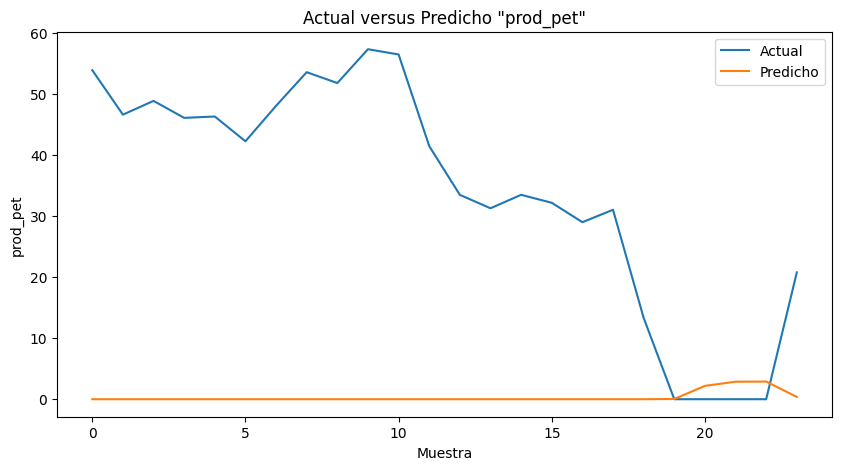

1/1 [==============================] - 0s 21ms/step
Predicciones para valores futuros de prod_pet: [0. 0. 0. 0. 0. 0.]


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_id_3640[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_id_3640['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_id_3640['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_id_3640['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_id_3640['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_id_3640['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_id_3640['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_id_3640['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_id_3640['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


1/1 [==============================] - 0s 310ms/step

1/1 [==============================] - 0s 182ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 195ms/step

1/1 [==============================] - 0s 208ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 262ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 192ms/step

1/1 [==============================] - 0s 263ms/step

100%|██████████| 10/10 [02:48<00:00, 16.81s/trial, best loss: 127.12804640010215]
Best batch size: 16
Best epochs: 100
Epoch 1/100
6/6 [==============================] - 2s 94ms/step - loss: 0.1324 - val_loss: 0.0194
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 0.0780 - val_loss: 0.0086
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0449 - val_loss: 0.0270
Epoch 4/100
6/6 [==============================

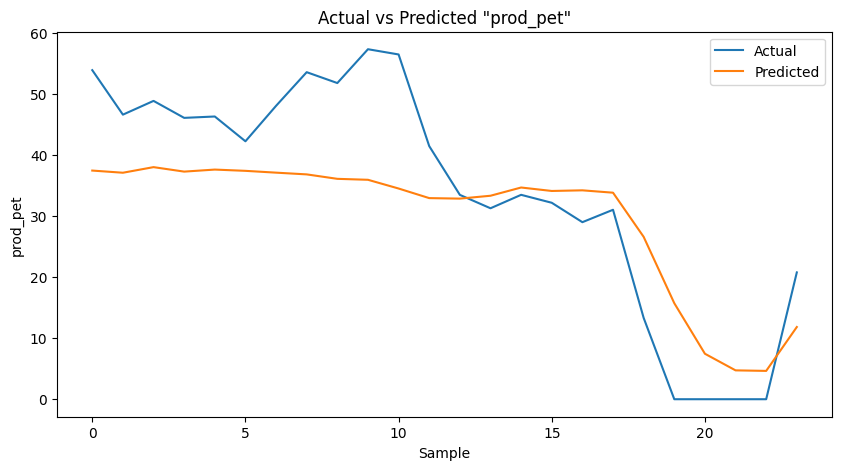

1/1 [==============================] - 0s 20ms/step
Predictions for future values of prod_pet: [18.047905 23.928806 23.725533 23.524336 23.32493  23.128391]


In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# Load the data (assuming filtered_data_id_3640 is already loaded)
# "X" contains the features
X = filtered_data_id_3640[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contains the target variable
y = filtered_data_id_3640['prod_pet']

# Scaling the features between 0 and 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scaling the target variable between 0 and 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Define sequence length
seq_length = 3

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Create sequences for LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Adjust "y" to align with the sequences
y_adjusted = y_scaled[seq_length - 1:]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Define the hyperparameter space
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Objective function to minimize (mean squared error)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Ensure non-negative predictions
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Run hyperparameter optimization
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

# Get the best hyperparameters
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Best batch size: {best_batch_size}')
print(f'Best epochs: {best_epochs}')

# Build the final model with the best hyperparameters
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Ensure non-negative predictions
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predict on the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform to get the actual predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate error metrics
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot the predicted vs actual values
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('prod_pet')
plt.title('Actual vs Predicted "prod_pet"')
plt.legend()
plt.show()

# Predict "prod_pet" for future values of "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Create a DataFrame with future values and placeholders for the other features
future_data = pd.DataFrame({
    'tef': [filtered_data_id_3640['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_id_3640['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_id_3640['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_id_3640['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_id_3640['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_id_3640['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_id_3640['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Scale the future data
scaled_future_data = scaler_X.transform(future_data)

# Create sequences for LSTM using the future scaled data
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Predict future values (scaled)
predictions_scaled = model.predict(future_sequences)

# Inverse transform to get the actual predictions
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predictions for future values of prod_pet:", predictions.flatten())


1/1 [==============================] - 0s 187ms/step

1/1 [==============================] - 0s 213ms/step

1/1 [==============================] - 0s 187ms/step

1/1 [==============================] - 0s 201ms/step

1/1 [==============================] - 0s 193ms/step

1/1 [==============================] - 0s 198ms/step

1/1 [==============================] - 0s 294ms/step

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 192ms/step

1/1 [==============================] - 0s 197ms/step

100%|██████████| 10/10 [02:49<00:00, 16.94s/trial, best loss: 123.6699661837444]
Mejor tamaño de lote: 32
Mejor cantidad de épocas: 100
Epoch 1/100
3/3 [==============================] - 1s 139ms/step - loss: 0.1733 - val_loss: 0.0471
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1400 - val_loss: 0.0315
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1106 - val_loss: 0.0195
Epoch 4/100
3/3 [============

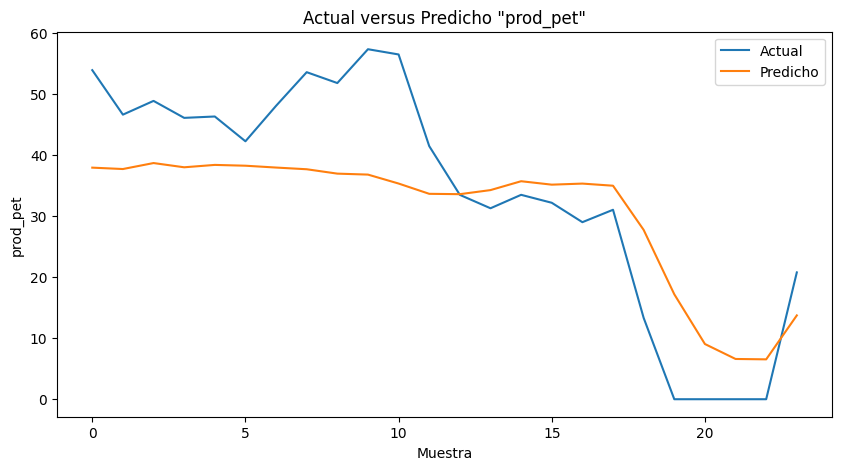

1/1 [==============================] - 0s 22ms/step
Predicciones para valores futuros de prod_pet: [20.149395 25.69169  25.549593 25.40745  25.265255 25.123014]


In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_id_3640[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_id_3640['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_id_3640['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_id_3640['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_id_3640['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_id_3640['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_id_3640['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_id_3640['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_id_3640['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


1/1 [==============================] - 0s 215ms/step

1/1 [==============================] - 0s 204ms/step

1/1 [==============================] - 0s 199ms/step

1/1 [==============================] - 0s 184ms/step

1/1 [==============================] - 0s 204ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 223ms/step

1/1 [==============================] - 0s 177ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [==============================] - 0s 177ms/step

1/1 [==============================] - 0s 202ms/step

1/1 [==============================] - 0s 204ms/step

1/1 [==============================] - 0s 206ms/step

1/1 [==============================] - 0s 193ms/step

1/1 [==============================] - 0s 287ms/step

1/1 [==============================] - 0s 198ms/step

1/1 [==============================] - 0s 212ms/step

1/1 [==============================] - 0s 195ms/step

1/1 [=======================

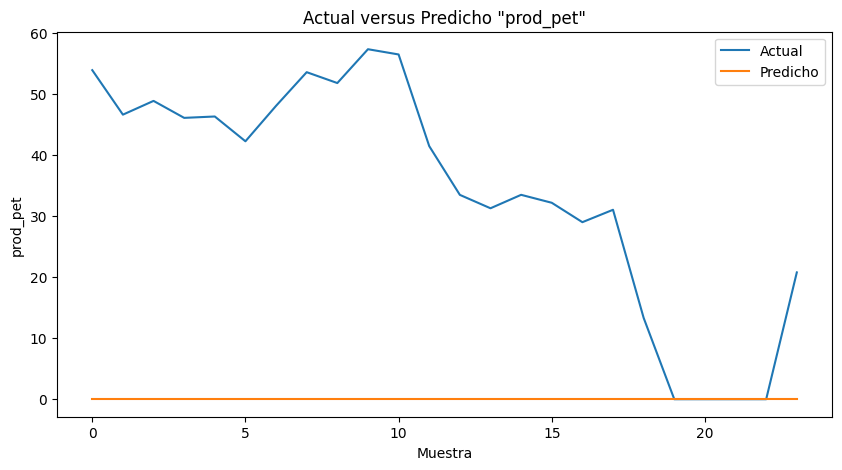

1/1 [==============================] - 0s 22ms/step
Predicciones para valores futuros de prod_pet: [0. 0. 0. 0. 0. 0.]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# "X" contiene los features
X = filtered_data_id_3640[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_id_3640['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)  # Aumentar max_evals

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_id_3640['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_id_3640['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_id_3640['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_id_3640['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_id_3640['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_id_3640['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_id_3640['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())


1/1 [==============================] - 0s 186ms/step

1/1 [==============================] - 0s 268ms/step

1/1 [==============================] - 0s 247ms/step

1/1 [==============================] - 0s 191ms/step

1/1 [==============================] - 0s 211ms/step

1/1 [==============================] - 0s 349ms/step

1/1 [==============================] - 0s 343ms/step

1/1 [==============================] - 0s 194ms/step

1/1 [==============================] - 0s 297ms/step

1/1 [==============================] - 0s 220ms/step

1/1 [==============================] - 0s 194ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 299ms/step

1/1 [==============================] - 0s 199ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 195ms/step

1/1 [=======================

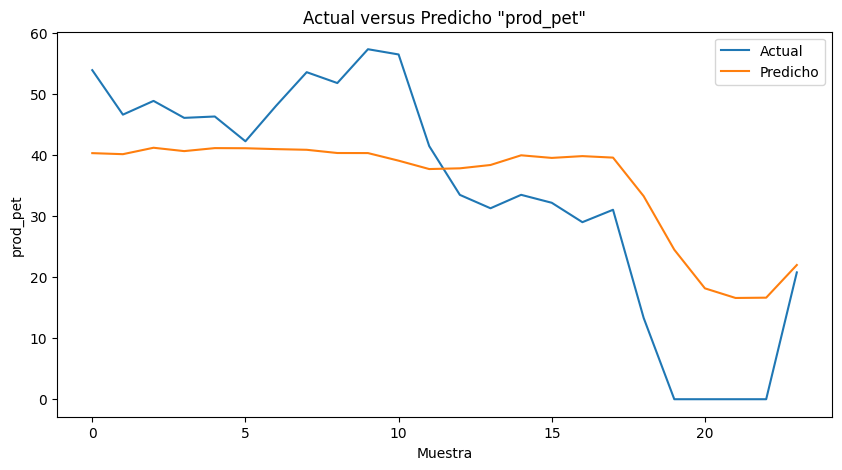

1/1 [==============================] - 0s 37ms/step
Predicciones para valores futuros de prod_pet: [26.859518 31.378742 31.339916 31.30173  31.263672 31.225609]


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# "X" contiene los features
X = filtered_data_id_3640[['tef', 'coordenadax', 'coordenaday', 'cota', 'pet_inicial', 'gas_inicial', 'agua_inicial', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_id_3640['prod_pet']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, la combinación de MSE y MAE)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Calcular el MSE y MAE
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

    # Combinar MSE y MAE en una única métrica
    combined_metric = 0.5 * mse + 0.5 * mae
    return combined_metric

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)  # Aumentar max_evals

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_pet')
plt.title('Actual versus Predicho "prod_pet"')
plt.legend()
plt.show()

# Predecir "prod_pet" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_id_3640['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_id_3640['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_id_3640['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_id_3640['cota'].iloc[-1]] * len(future_date_numeric_values),
    'pet_inicial': [filtered_data_id_3640['pet_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'gas_inicial': [filtered_data_id_3640['gas_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'agua_inicial': [filtered_data_id_3640['agua_inicial'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_pet:", predictions.flatten())
